In [1]:
import pickle
import sys

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

PWD = '../../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
DATASET_NOISYSAT_PATH = PWD + '/data/dataset/dataset_noisysat.pkl'

PRINT_PCOV = False

N_BASELINE = 6

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.10, 0.20, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

with open(DATASET_NOISYSAT_PATH, 'rb') as file:
    dataset_noisysat = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=1,
                batch_size=BATCH_SIZE, lr_patience=5, es_patience=60, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/noisysat/trained_on_all', X_train, y_train, X_val, y_val,
                             lr, train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta,
                             loss_weights, root=PWD + '/data')

# Optimal CFD thresholds

In [6]:
# from src.cfd import find_optimal_cfd_threshold
#
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
#     X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=0.25, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, X_train, y_train, X_TIME, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

In [7]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.185
(1, 11): 0.200
(2,  2): 0.235
(2, 11): 0.170
(3,  2): 0.145
(3, 11): 0.195


# Train the network

In [8]:
train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
for (plane, channel) in dataset.keys():
    X_filtered, y_filtered = dataset[(plane, channel)]
    X_noisysat, y_noisysat = dataset_noisysat[(plane, channel)]
    X = np.concatenate([X_filtered, X_noisysat])
    y = np.concatenate([y_filtered, y_noisysat])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                        random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    train_X_list.append(X_train)
    train_y_list.append(Y_heatmap_train)
    test_X_list.append(X_test)
    test_y_list.append(Y_heatmap_test)

X_train_all = np.concatenate(train_X_list)
y_train_all = np.concatenate(train_y_list)
X_test_all = np.concatenate(test_X_list)
y_test_all = np.concatenate(test_y_list)

X_train_all.shape, y_train_all.shape, X_test_all.shape, y_test_all.shape

((109410, 24), (109410, 24), (27354, 24), (27354, 24))

In [9]:
model = optimal_model_builder_all_ch()
history = train_model(model, "optimal", X_train=X_train_all, y_train=y_train_all, X_val=X_test_all, y_val=y_test_all,
                      train=False)

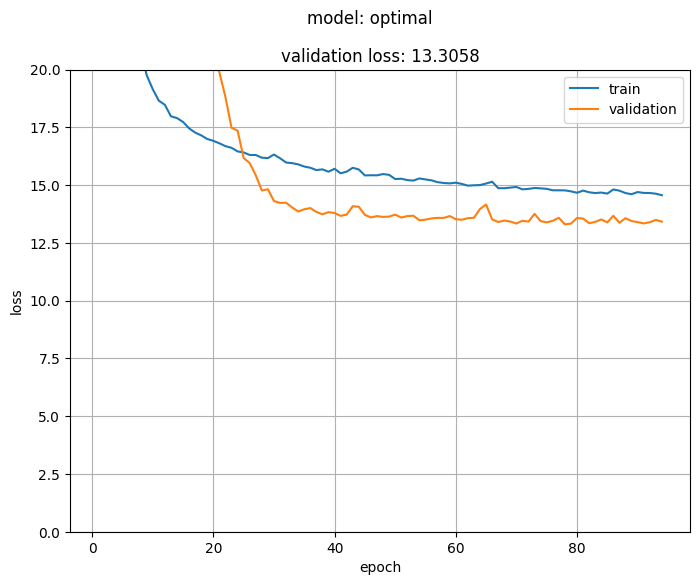

In [10]:
plot_history(history, f'model: optimal', ymax=20)

# Test

In [11]:
improvements = {}
for (plane, channel), (all_X, all_y) in dataset_noisysat.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd = np.std(y_pred_cfd - y_test)
    # std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    y_pred_model = model_predict(model, X_test)
    std_model = np.std(y_pred_model - y_test)
    # std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

Processing p=1, ch=2...
1/1 [==============================] - 1s 656ms/step
       CFD: 189.67 ps
   optimal: 151.13 ps (improvement: 20.32 %)
Processing p=1, ch=11...
1/1 [==============================] - 0s 47ms/step
       CFD: 180.31 ps
   optimal: 125.23 ps (improvement: 30.55 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 78ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 190.03 ps
   optimal: 145.55 ps (improvement: 23.41 %)
Processing p=2, ch=11...
1/1 [==============================] - 0s 110ms/step
       CFD: 185.86 ps
   optimal: 149.18 ps (improvement: 19.73 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 94ms/step
       CFD: 269.30 ps
   optimal: 250.68 ps (improvement: 6.92 %)
Processing p=3, ch=11...
1/1 [==============================] - 0s 47ms/step
       CFD: 351.90 ps
   optimal: 215.88 ps (improvement: 38.65 %)


In [12]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD: 189.67 ps, NN: 151.13 (20.32 %)
(1, 11) CFD: 180.31 ps, NN: 125.23 (30.55 %)
(2,  2) CFD: 190.03 ps, NN: 145.55 (23.41 %)
(2, 11) CFD: 185.86 ps, NN: 149.18 (19.73 %)
(3,  2) CFD: 269.30 ps, NN: 250.68 ( 6.92 %)
(3, 11) CFD: 351.90 ps, NN: 215.88 (38.65 %)
